<a href="https://colab.research.google.com/github/diwert-ai/TestTask_PleuralEffSegmentation/blob/master/baseline_refactored.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab preset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET =     {'train': 'subset.zip'}
INPUT_DIR ='/content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/input/'
OUTPUT_DIR = '/content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/output/'

WORK_DIR='/content/'
EXPERIMENT='test4'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'

DATASET_DIR = INPUT_DIR
METADATA_DIR = INPUT_DIR

IMPORT_DIR = '/content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/nbs/py/'

In [4]:
def copy_dataset(ds_dict, ds_dir, work_dir):
  for record in ds_dict:
    print('copy', ds_dir+ds_dict[record], ' to', work_dir)
    !cp {ds_dir+ds_dict[record]} {work_dir}
    #print('mkdir',work_dir+record)
    #!mkdir {work_dir+record}
    print ('unzip -q ',work_dir+ds_dict[record],' -d ',work_dir)
    !unzip -q  {work_dir+ds_dict[record]} -d {work_dir}
    print ('rm ',work_dir+ds_dict[record])
    !rm {work_dir+ds_dict[record]}


copy_dataset(DATASET,DATASET_DIR, WORK_DIR)
!unzip -q  /content/subset/subset_img.zip -d /content/subset
!unzip -q  /content/subset/subset_masks.zip -d /content/subset
!ls /content/

copy /content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/input/subset.zip  to /content/
unzip -q  /content/subset.zip  -d  /content/
rm  /content/subset.zip
drive  sample_data  subset


In [5]:
!ls /content/subset

subset	subset_img.zip	subset_masks  subset_masks.zip


In [6]:
!mkdir {EXPERIMENT_DIR}

mkdir: cannot create directory ‘/content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/output/test4/’: File exists


# Install packages

In [7]:
!pip install --upgrade SimpleITK
!pip install --upgrade segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 130 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 7.8 MB/s 
     |████████████████████████████████| 58 kB 7.6 MB/s 
     |████████████████████████████████| 376 kB 56.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=8de15c431b18bb54c9fda38070b8a444e572fc1ac0cc4040dc2f386288b22d70
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=489e3c147bebff58fc78adbb265c1c880e0d8d57b002479389c9d2dff298d95d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully

# Imports

In [8]:
import sys
sys.path.append(IMPORT_DIR)

In [9]:
import numpy as np
import random
import torch
import torch.optim as optim
import torch.utils.data as data
from torch.cuda import amp
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')
import os
import gc
import time
from collections import defaultdict
from tqdm.notebook import tqdm

from config import Config
from preprocess import DataPreprocessor
from dataset import PleuralEffDataset
from model import ModelWrapper
from augment import make_train_augmenter, make_test_augmenter
from dice_coeff import dice_coefficient

# Pipeline

In [10]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)


def prepare_test_loader(debug=False):
    test_df = df_train.query("split=='test'").reset_index(drop=True)
    if debug:
        test_df = test_df.head(Config.batch_size * 1)
    test_dataset = PleuralEffDataset(test_df, transform=test_aug)
    p_test_loader = data.DataLoader(test_dataset,
                                    batch_size=Config.batch_size,
                                    num_workers=Config.num_workers,
                                    sampler=data.SequentialSampler(test_dataset),
                                    pin_memory=True)
    return p_test_loader


def prepare_loaders(debug=False):
    train_df = df_train.query("split=='train'").reset_index(drop=True)
    valid_df = df_train.query("split=='valid'").reset_index(drop=True)
    if debug:
        train_df = train_df.head(Config.batch_size * 3)
        valid_df = valid_df.head(Config.batch_size * 1)
    train_dataset = PleuralEffDataset(train_df, transform=train_aug)
    valid_dataset = PleuralEffDataset(valid_df, transform=test_aug)

    p_train_loader = data.DataLoader(train_dataset,
                                     batch_size=Config.batch_size,
                                     num_workers=Config.num_workers,
                                     worker_init_fn=lambda x: np.random.seed(torch.initial_seed() // 2 ** 32 + x),
                                     sampler=data.RandomSampler(train_dataset),
                                     pin_memory=True,
                                     drop_last=False)

    p_valid_loader = data.DataLoader(valid_dataset,
                                     batch_size=Config.batch_size,
                                     num_workers=Config.num_workers,
                                     sampler=data.SequentialSampler(valid_dataset),
                                     pin_memory=True)

    return p_train_loader, p_valid_loader


def criterion(y_pred, y_true):
    return dice_loss(y_pred, y_true)


@torch.no_grad()
def do_inference():
    model.eval()
    pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc='Test ')
    test_dice_list = []
    for step, (images, masks) in pbar:
        images = images.to(Config.device, dtype=torch.float)
        masks = masks.to(Config.device, dtype=torch.float)
        y_pred = model(images)
        y_pred = sigmoid(y_pred).round().to(torch.float32)
        test_dice_list.append(dice_coefficient(masks, y_pred).item())
    test_dice_mean = np.mean(test_dice_list)
    torch.cuda.empty_cache()
    _ = gc.collect()
    return test_dice_mean


@torch.no_grad()
def do_valid():
    model.eval()
    valid_dice_list, valid_loss_list = [], []
    valid_dice_mean, valid_loss_mean = 0, 0
    dataloader_len = len(valid_loader)
    pbar = tqdm(enumerate(valid_loader), total=dataloader_len, desc='Valid ')

    for step, (images, masks) in pbar:
        images = images.to(Config.device, dtype=torch.float)
        masks = masks.to(Config.device, dtype=torch.float)

        with amp.autocast(enabled=True):
            y_pred = model(images)

        valid_loss_list.append(criterion(y_pred, masks).item())
        valid_loss_mean = np.mean(valid_loss_list)
        y_pred = sigmoid(y_pred).round().to(torch.float32)
        valid_dice_list.append(dice_coefficient(masks, y_pred).item())
        valid_dice_mean = np.mean(valid_dice_list)
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valloss=f'{valid_loss_mean:0.4f}',
                         valdice=f'{valid_dice_mean:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpumem=f'{mem:0.2f} GB')

    torch.cuda.empty_cache()
    _ = gc.collect()

    return valid_loss_mean, valid_dice_mean


def train_one_epoch(epoch, best_metrics, history, valid_steps):
    model.train()
    scaler = amp.GradScaler()
    train_dice_list, train_loss_list = [], []
    train_dice_mean, train_loss_mean = 0, 0
    dataloader_len = len(train_loader)
    pbar = tqdm(enumerate(train_loader), total=dataloader_len, desc='Train ')
    for step, (images, masks) in pbar:
        images = images.to(Config.device, dtype=torch.float)
        masks = masks.to(Config.device, dtype=torch.float)

        with amp.autocast(enabled=True):
            y_pred = model(images)
            loss = criterion(y_pred, masks)

        train_loss_list.append(loss.item())
        train_loss_mean = np.mean(train_loss_list)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        y_pred = sigmoid(y_pred).round().to(torch.float32)
        train_dice_list.append(dice_coefficient(masks, y_pred).item())
        train_dice_mean = np.mean(train_dice_list)

        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(trloss=f'{train_loss_mean:0.4f}',
                         trdice=f'{train_dice_mean:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpumem=f'{mem:0.2f} GB')

        if step + 1 in valid_steps:
            valid_loss_mean, valid_dice_mean = do_valid()
            history['Train Loss'].append(train_loss_mean)
            history['Train Dice'].append(float(train_dice_mean))
            history['Valid Loss'].append(valid_loss_mean)
            history['Valid Dice'].append(float(valid_dice_mean))
            history['Learning Rate'].append(current_lr)
            history['Memory Usage'].append(mem)

            if float(valid_dice_mean) > best_metrics['best_dice']:
                print(f"Valid Dice Coefficient Improved: {best_metrics['best_dice']:0.4f} ---> {valid_dice_mean:0.4f}")
                best_metrics['best_dice'] = float(valid_dice_mean)
                best_metrics['best_epoch'] = epoch

                suffix = f"best_valid_[ep_{epoch}]_{valid_dice_mean:0.4f}"
                model_filename = data_p.paths['exp dir'] + suffix + '.bin'
                torch.save(model.state_dict(), model_filename)
                print(f'test dice: {do_inference():0.4f}')
                model.train()

    torch.cuda.empty_cache()
    _ = gc.collect()

    return train_loss_mean, train_dice_mean


def run_training():
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    start = time.time()
    best_metrics = {'best_dice': 0,
                    'best_epoch': -1}
    history = defaultdict(list)
    train_len = len(train_loader)
    valid_steps = [train_len - i * train_len // Config.val_freq for i in range(Config.val_freq)]
    for epoch in range(1, Config.epochs + 1):
        _ = gc.collect()
        print(f'Epoch {epoch}/{Config.epochs}', end='')
        train_one_epoch(epoch=epoch, best_metrics=best_metrics, history=history, valid_steps=valid_steps)
        scheduler.step()
        # save_last_state(model,optimizer,scheduler,epoch,history,best_params)
        print('\n\n')
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Valid Dice: {:.4f}".format(best_metrics['best_dice']))

    return history


def fetch_scheduler():
    f_scheduler = None
    if Config.scheduler == 'CosineAnnealingLR':
        f_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.t_max, eta_min=Config.min_lr)
    elif Config.scheduler == 'CosineAnnealingWarmRestarts':
        f_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=Config.t_0, eta_min=Config.min_lr)
    elif Config.scheduler == 'ReduceLROnPlateau':
        f_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.333, patience=5,
                                                           threshold=0.0001,
                                                           min_lr=0, verbose=True)
    elif Config.scheduler == 'ExponentialLR':
        f_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    return f_scheduler


def plot_and_save_histories():
    fig, axs = plt.subplots(2, len(histories), sharex=True, figsize=(20, 15))
    fig.suptitle('histories')

    def plot_history(keys, styles, num):
        x = list(range(len(histories[fold][keys[0]])))
        for i, key in enumerate(keys):
            y = histories[fold][key]
            axs[num].plot(x, y, styles[i], label=key)
        axs[num].set_title(fold)
        axs[num].legend()

    for n_fold, fold in enumerate(histories):
        plot_history(['Train Dice', 'Valid Dice'], ['o--', 'v:'], 0)
        plot_history(['Learning Rate'], ['o--'], 1)
    plt.show()
    fig.savefig(data_p.paths['exp dir'] + 'fig.png')

slicing 3d masks : 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


1087: total images saved
1087: total masks saved


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

cuda: Tesla T4

Epoch 1/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]

Valid Dice Coefficient Improved: 0.0000 ---> 0.1968


Test :   0%|          | 0/3 [00:00<?, ?it/s]

test dice: 0.1681



Epoch 2/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 3/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 4/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 5/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 6/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 7/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]

Valid Dice Coefficient Improved: 0.1968 ---> 0.3033


Test :   0%|          | 0/3 [00:00<?, ?it/s]

test dice: 0.2312



Epoch 8/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 9/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 10/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 11/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]

Valid Dice Coefficient Improved: 0.3033 ---> 0.5822


Test :   0%|          | 0/3 [00:00<?, ?it/s]

test dice: 0.3299



Epoch 12/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 13/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 14/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 15/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]

Valid Dice Coefficient Improved: 0.5822 ---> 0.5960


Test :   0%|          | 0/3 [00:00<?, ?it/s]

test dice: 0.4666



Epoch 16/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 17/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 18/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 19/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 20/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]

Valid Dice Coefficient Improved: 0.5960 ---> 0.6066


Test :   0%|          | 0/3 [00:00<?, ?it/s]

test dice: 0.4799



Epoch 21/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 22/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 23/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 24/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 25/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 26/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 27/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 28/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 29/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 30/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Training complete in 0h 17m 8s
Best Valid Dice: 0.6066


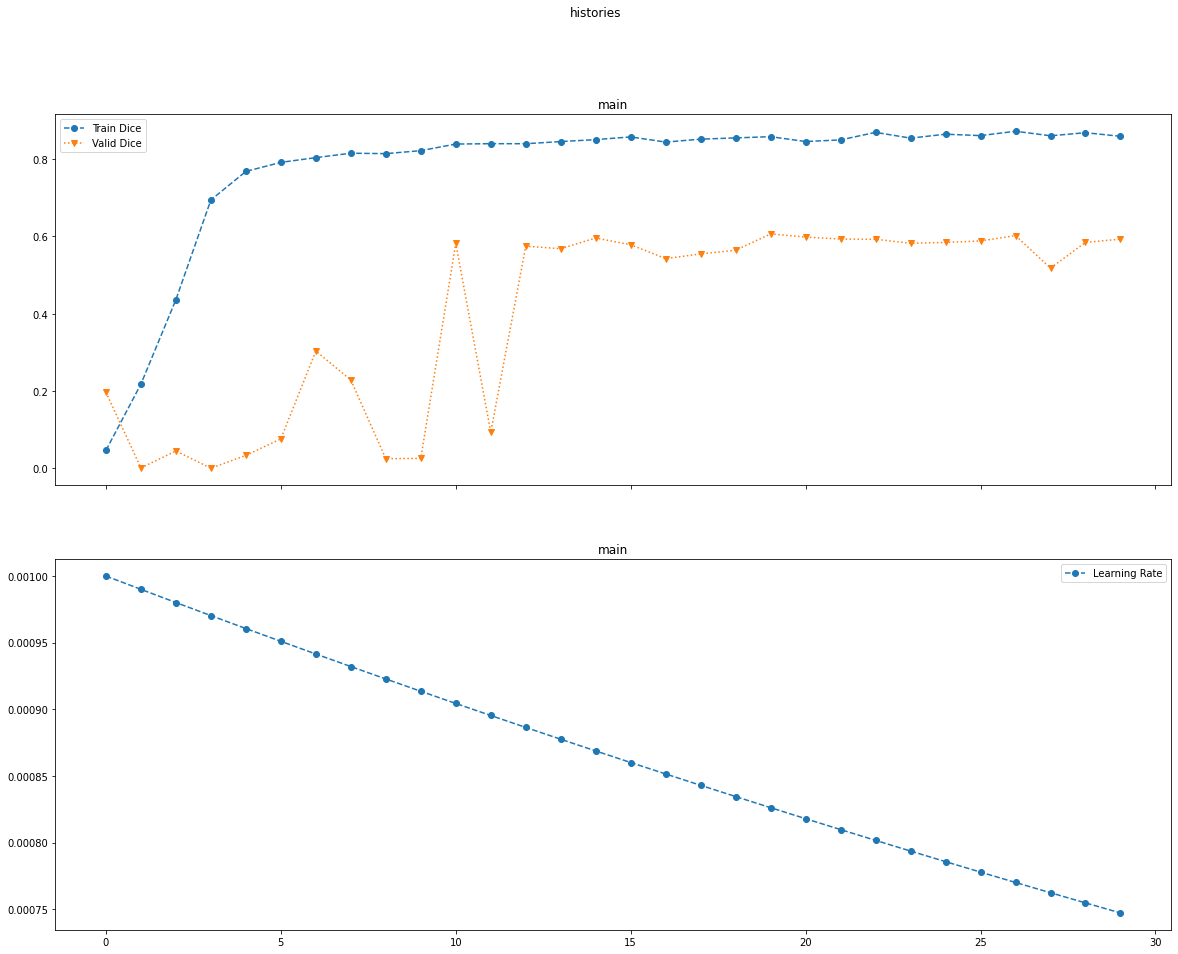

In [11]:
paths = {'root dir': '/content/',
         'exp dir': EXPERIMENT_DIR,
         '3d images dir': '/content/subset/subset/',
         '3d masks dir':'/content/subset/subset_masks/',
         '3d images files': '/content/subset/subset/L*/*/*/*',
         '3d masks files': '/content/subset/subset_masks/L*/*gz',
         'images train': '/content/train/',
         'masks train': '/content/train/masks/'}
!mkdir {paths['images train']}
!mkdir {paths['masks train']}
set_seed(Config.seed)
data_p = DataPreprocessor(paths)
df_train = data_p.run()
train_aug, test_aug = make_train_augmenter(), make_test_augmenter()
dice_loss = smp.losses.DiceLoss(mode='binary')
sigmoid = torch.nn.Sigmoid()
test_loader = prepare_test_loader(debug=Config.debug)
train_loader, valid_loader = prepare_loaders(debug=Config.debug)
histories = dict()
model = ModelWrapper()
model.to(Config.device)
optimizer = optim.Adam(model.parameters(), lr=Config.lr, weight_decay=Config.wd)
scheduler = fetch_scheduler()
histories['main'] = run_training()
plot_and_save_histories()

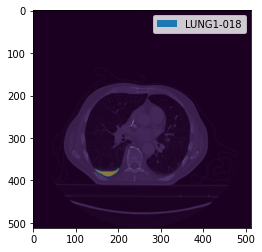

In [12]:
data_p.get_3d_masked_img_ani(3, 30, 60)